In [1]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv, lstsq

from poly_basis import *
from spherepts import *
from rbf import *

from math import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [9]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below
        harm_index = 20

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

In [96]:
n = 400
k = 25
c = 100
rbf_obj = rbf_dict['multiquadric']
eps = 3
# foo, exact = get_exact('gaussians')
foo, exact = get_exact(0)

nodes = gen_spiral_nodes(n)
normals = nodes
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[c], k)[1]
nn = nodes[stencil]

Harmonic degree: 4


<IPython.core.display.Javascript object>


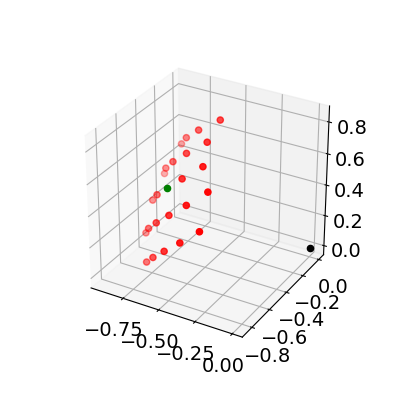

In [97]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nn[1:,0], nn[1:,1], nn[1:,2], '.', color='r')
ax.scatter(nn[0,0], nn[0,1], nn[0,2], '.', color='g')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

In [80]:
phi  = rbf_obj['rbf']
phi1 = rbf_obj['zeta']
phi2 = rbf_obj['chi']
phi3 = rbf_obj['beta']
phi4 = rbf_obj['gamma']
d2phi = rbf_obj['d2rbf']
def Gx(r, d, eps):
    return d*phi1(r,eps)
def Hx(r, d,eps):
    return phi1(r,eps) + d**2 * phi2(r,eps)
def GHx(r, d,eps):
    return 3*d*phi2(r,eps) + d**3 * phi3(r,eps)
def HHx(r, d,eps):
    return 3*phi2(r,eps) + 6 * d**2 * phi3(r,eps) + d**4 * phi4(r,eps)
def Lphi(r, eps):
    return 2*phi1(r,eps) + d2phi(r,eps)
def LG(r, d,eps):
    return 4*d*phi2(r,eps) + r**2 * d * phi3(r,eps)
def LH(r,d,eps):
    return 5*phi2(r,eps) + (r**2 + 7*d**2)*phi3(r,eps) + (d*r)**2 * phi4(r,eps)

In [98]:
(nn - nn[0]) @ nn[0]

array([ 0.        , -0.0140048 , -0.01409987, -0.01966792, -0.02024285,
       -0.02093899, -0.02420196, -0.0446906 , -0.04547935, -0.0478414 ,
       -0.05567559, -0.05677212, -0.06554747, -0.06951657, -0.07125286,
       -0.07467681, -0.07668598, -0.08479745, -0.0919485 , -0.09476177,
       -0.10604948, -0.10804531, -0.11579177, -0.11598626, -0.11986125])

In [110]:
r = dist_outer(nn,nn)
d = (nn - nn[0]) @ nn[0]
B = np.zeros((k,k+2))

B[:,:k] = Lphi(r, eps)
B[:,-2] = LG(r[0], d, eps)
B[:,-1] = LH(r[0], d, eps)

A = np.zeros((k+2,k+2))
A[:k, :k] = phi(r, eps)
A[:k, -2] = Gx(r[0], d, eps)
A[-2, :k] = -A[:k, -2]
A[:k, -1] = Hx(r[0], d, eps)
A[-1, :k] = A[:k, -1]
A[-2, -2] = -Hx(0, 0, eps)
A[-2, -1] = -GHx(0, 0, eps)
A[-1, -2] = -A[-2, -1]
A[-1, -1] = HHx(0, 0, eps)

print(np.log(cond(A)))

# C = (B @ la.inv(A))[:,:k]
C = la.solve(A.T, B.T).T[:,:k]

fs = np.array([foo(node) for node in nn])
ds = np.array([exact(node) for node in nn])

rel_error_L2  = la.norm(C@fs - ds)/la.norm(ds)
print(rel_error_L2)

10.62165201935296
0.6125519211023708


In [107]:
C = (B @ la.inv(A))
C2 = la.solve(A.T, B.T).T
print(C - C2)

[[-5.37170308e-12  6.49436060e-12  6.26698693e-12  8.31335001e-13
  -1.96820338e-12  5.45696821e-12  2.33768560e-12 -2.56861199e-12
  -8.99724739e-12 -1.95399252e-13 -7.39142081e-12 -7.44293516e-13
  -3.49675844e-12 -2.41158205e-11 -1.48148160e-12  1.04360964e-12
   2.06070716e-11  2.07711626e-11  6.74393874e-12  7.47779616e-12
   2.00328643e-12 -1.10764731e-11  2.55706567e-12 -7.52509166e-13
  -8.84126106e-12 -4.88498131e-15  1.33226763e-15]
 [ 1.00186526e-11 -1.70530257e-12 -9.72733005e-12 -7.02016223e-12
  -3.04112291e-12 -2.51887400e-12  2.72315503e-12  4.26325641e-12
   9.20685750e-12  5.97566441e-12 -1.51345603e-12  2.91899838e-12
   2.65432121e-12  1.45528034e-11  4.05719902e-12 -1.55964130e-12
  -1.15480958e-11 -1.30747912e-11 -4.92539343e-12 -3.62554431e-12
  -3.14415161e-13  5.73660563e-12 -3.05688808e-12 -7.58504370e-13
   6.06917294e-12  2.88657986e-15  8.99280650e-15]
 [-1.15107923e-12  1.65201186e-13  6.11066753e-12 -1.39621648e-12
   1.47242218e-11 -1.97495353e-11 -4.462

ValueError: operands could not be broadcast together with shapes (25,25) (25,27) 

In [102]:
rhs = np.zeros(k+2)
rhs[:k] = fs
c = la.solve(A, rhs)

In [103]:
A @ c - rhs

array([-2.39808173e-14, -1.68753900e-14,  1.68753900e-14,  1.24344979e-14,
        1.42108547e-14,  1.50990331e-14,  1.77635684e-14,  3.99680289e-15,
       -7.10542736e-15,  1.86517468e-14, -1.37667655e-14, -1.42108547e-14,
        3.46389584e-14, -1.88737914e-14, -1.77635684e-15,  6.21724894e-15,
       -1.77635684e-15, -2.22044605e-15,  1.33226763e-14,  2.35367281e-14,
       -1.46549439e-14,  1.33226763e-14,  1.59872116e-14,  3.55271368e-14,
        2.30926389e-14,  0.00000000e+00,  0.00000000e+00])

In [90]:
np.array().reshape(k+2)

ValueError: cannot reshape array of size 3 into shape (27,)

In [91]:
fs

array([1.85560936, 1.7183561 , 2.03535602, 1.86511438, 1.74865216,
       1.9016031 , 2.0539581 , 1.63312347, 2.08796366, 1.72775574,
       1.61766226, 2.2614649 , 2.30773016, 1.85646679, 2.12460903,
       1.91401824, 1.69691429, 2.0572738 , 2.29541235, 1.55028922,
       1.63088726, 1.58457381, 2.42219062, 1.76719214, 2.26421709])